In [1]:
# Importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
tf.__version__

'2.4.1'

In [11]:
pwd

'/Users/kushalvala/Documents/Notebooks/fastapi-nlp/FastAPI-Keras'

In [12]:
# Reading the dataset
df = pd.read_csv('/Users/kushalvala/Documents/Notebooks/IMDB Dataset.csv')

In [13]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
# There are 50k reviews of movies.
df.shape

(50000, 2)

In [15]:
# It's a balanced distribution of both sentiments
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

Encoding the sentiment:  
negative - 0 , positive - 1

In [16]:
df['sentiment'] = df['sentiment'].map({'positive' : 1, 'negative': 0})

In [17]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Estimation of Vocabulary of Corpus

In [18]:
df_temp = df.copy()

In [19]:
from nltk.corpus import stopwords 
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [20]:
df_temp['review'] = df_temp['review'].str.lower()
df_temp['review'] =  df_temp['review'].apply(lambda x: re.sub(r'\W+|\d+|(br)',' ', str(x)))
df_temp['review'] = df_temp['review'].apply(lambda x: x.rstrip())
df_temp['review'] = df_temp['review'].apply(lambda x : ' '.join([w for w in x.split() if not w in stop_words]))

In [21]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [22]:
df_temp['review'][0]

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz utality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills 

In [23]:
corpus = ' '.join(df_temp['review'].tolist())
word_dist = nltk.FreqDist(corpus.split())

In [24]:
for i in [1000,5000,7500,10000,12000,15000,20000]:
    most_words = word_dist.most_common(i)
    print('Percentage of Corpus captured with %s words is %.2f'%(i,np.sum([int(x[1]) for x in most_words]) / len(corpus.split()) * 100 ))

Percentage of Corpus captured with 1000 words is 57.38
Percentage of Corpus captured with 5000 words is 82.00
Percentage of Corpus captured with 7500 words is 86.86
Percentage of Corpus captured with 10000 words is 89.84
Percentage of Corpus captured with 12000 words is 91.52
Percentage of Corpus captured with 15000 words is 93.36
Percentage of Corpus captured with 20000 words is 95.33


__We will choose 12,000 vocab size for our corpus__

Estimating the length of vector

In [25]:
df_temp.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


In [26]:
len(df_temp['review'][0].split())

162

In [27]:
corpus_list = df_temp['review'].tolist()

In [28]:
len_review = []
for i in corpus_list:
    len_review.append(len(i.split()))

In [29]:
len_review = np.array(len_review)

In [30]:
print('Average Length of Review:', np.mean(len_review))
print('Std Deviation of Reviews:', np.std(len_review))

Average Length of Review: 118.12304
Std Deviation of Reviews: 89.39626648332914


In [31]:
mean = np.mean(len_review)
std = np.std(len_review)

for i in range(3):
    print('Percentage of Reviews less than or equal to mean + %s standard dev: %.2f'%(i,len(len_review[len_review <= np.mean(len_review) + i * np.std(len_review)]) / len(len_review)))

Percentage of Reviews less than or equal to mean + 0 standard dev: 0.67
Percentage of Reviews less than or equal to mean + 1 standard dev: 0.87
Percentage of Reviews less than or equal to mean + 2 standard dev: 0.95


87% of reviews are less than mean + 1 std dev length, which will be our optimal length of vector.

In [32]:
print('Length of Vector is', np.round(mean+std,2))

Length of Vector is 207.52


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size = 0.2)

In [34]:
X_train.shape, X_test.shape

((40000,), (10000,))

In [35]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes= 2)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes= 2)

In [36]:
# Load data using tf.data.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [37]:
for feat, targ in train_dataset.take(1):
  print('text: ', feat.numpy())
  print('label: ', targ.numpy())

text:  b"i originally seen the flash Gordon serial on PBS,and thought it was fun and awesome,i overlooked the special effects of the rocket ships with sparklers,and the big dragon monster with lobster claws,who cares this is 1936 and it was a serial,so each week they would show a new chapter, buster Crabbe played flash Gordon 3 times,in all 3 serials.then in 1939 he played buck rogers,in 1933 he played Tarzan the fearless.he was a very busy actor.beautiful jean rogers played sexy dale Arden.frank Shannon as professor zarkov,and Charles Middleton played the evil ming the merciless.he makes Darth Vader look like a boyscout.the serials were very close to the Alex Raymond comic strip.space travel was just a pipe dream at the time.not to mention ray guns and television.this one stands out as the best serial ever.the sequel flash Gordon's trip to mars is 2 chapters longer,the next flash Gordon conquers the universe is only 12 chapters.and then there's the natives of mongo..,hawk-men, lion-me

In [38]:
BUFFER_SIZE = 20000
BATCH_SIZE = 512

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [39]:
# @tf.keras.utils.register_keras_serializable()
# def custom_standardization(input_data):
#     lowercase = tf.strings.lower(input_data)
#     output = tf.strings.regex_replace(lowercase, "\W+|(br)|\d+", " ")
#     return output

In [40]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = VOCAB_SIZE, standardize = 'lower_and_strip_punctuation',
    output_mode = 'int', output_sequence_length = 200,
)

In [41]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [42]:
vocab = np.array(encoder.get_vocabulary())

In [43]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This movie was heavily marred by the presence of Steven Seagal. Or as I should say Steven So-dull! Like before Seagal is either too good or too stupid to re-dub his own lines, leaving someone to impersonate his voice for the shots where the sound needed to be looped. A few films before this was he has done this too, but I don't think to this extent! To be honest the film looks pretty good, the script could use some work but parts of this film looked like a real movie! Of course, all told, this film is pretty bad.<br /><br />It would have been much better without Seagal who has become a cartoon of himself. Don't bother. Anything over a buck for this one is too much! I honestly think this is the last time for me and a Seagal film. What's taken me so long to realize this?!"
 b'Very few so called "remakes" can be as good as the originals. This one crosses that border with flying colors. Just a remake, I don\'t think so! I saw it theatrically at the age of nine, and was completel

In [44]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  11,   18,   14, 2640,    1,   33,    2, 1264,    5, 1933, 2291,
          40,   15,   10,  140,  129, 1933,    1,   39,  157, 2291,    7,
         351,  101,   50,   40,  101,  365,    6,    1,   25,  198,  407,
        1164,  285,    6,    1,   25,  599,   17,    2,  634,  113,    2,
         437,  857,    6,   27,    1,    3,  166,   94,  157,   11,   14,
          28,   45,  224,   11,  101,   19,   10,   90,  103,    6,   11,
        2893,    6,   27, 1198,    2,   20,  273,  177,   50,    2,  228,
          97,  344,   47,  164,   19,  501,    5,   11,   20,  571,   39,
           3,  145,   18,    5,  259,   32,  550,   11,   20,    7,  177,
        3142,   13,    9,   59,   26,   75,   73,  124,  200, 2291,   37,
          45,  412,    3, 1076,    5,  312,   90, 1207,  229,  128,    3,
        3404,   17,   11,   29,    7,  101,   73,   10, 1165,  103,   11,
           7,    2,  235,   60,   17,   70,    4,    3, 2291,   20,  690,
         592,   70,   38,  202,    6, 

In [45]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This movie was heavily marred by the presence of Steven Seagal. Or as I should say Steven So-dull! Like before Seagal is either too good or too stupid to re-dub his own lines, leaving someone to impersonate his voice for the shots where the sound needed to be looped. A few films before this was he has done this too, but I don't think to this extent! To be honest the film looks pretty good, the script could use some work but parts of this film looked like a real movie! Of course, all told, this film is pretty bad.<br /><br />It would have been much better without Seagal who has become a cartoon of himself. Don't bother. Anything over a buck for this one is too much! I honestly think this is the last time for me and a Seagal film. What's taken me so long to realize this?!"
Round-trip:  this movie was heavily [UNK] by the presence of steven seagal or as i should say steven [UNK] like before seagal is either too good or too stupid to [UNK] his own lines leaving someone to [UNK

In [46]:
from tensorflow.keras.layers import Bidirectional,LSTM, Dense, Embedding, Dropout, GlobalAveragePooling1D

In [47]:
model = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim= 256, mask_zero=True),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')])

In [48]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001), 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits= False), metrics = ['accuracy']
              )

In [49]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=5)

Epoch 1/10
79/79 [==============================] - 16s 197ms/step - loss: 0.6497 - accuracy: 0.6673 - val_loss: 0.3784 - val_accuracy: 0.8355
Epoch 2/10
79/79 [==============================] - 15s 186ms/step - loss: 0.3457 - accuracy: 0.8512 - val_loss: 0.3112 - val_accuracy: 0.8687
Epoch 3/10
79/79 [==============================] - 15s 186ms/step - loss: 0.2755 - accuracy: 0.8834 - val_loss: 0.3052 - val_accuracy: 0.8711
Epoch 4/10
79/79 [==============================] - 15s 192ms/step - loss: 0.2536 - accuracy: 0.8957 - val_loss: 0.3110 - val_accuracy: 0.8699
Epoch 5/10
79/79 [==============================] - 15s 185ms/step - loss: 0.2389 - accuracy: 0.9038 - val_loss: 0.3162 - val_accuracy: 0.8727
Epoch 6/10
79/79 [==============================] - 15s 185ms/step - loss: 0.2283 - accuracy: 0.9074 - val_loss: 0.3241 - val_accuracy: 0.8703
Epoch 7/10
79/79 [==============================] - 15s 184ms/step - loss: 0.2247 - accuracy: 0.9103 - val_loss: 0.3305 - val_accuracy: 0.8680

In [50]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

20/20 [==============================] - 2s 99ms/step - loss: 0.3457 - accuracy: 0.8626
Loss:  0.3457462191581726
Accuracy:  0.8626000285148621


In [51]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

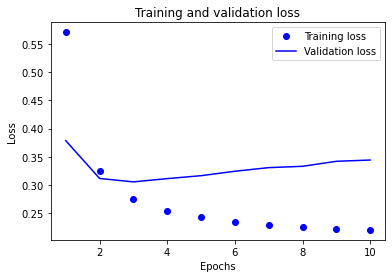

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

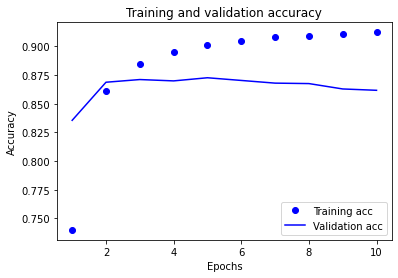

In [53]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [54]:
example = ['GODZILLA VS. KONG is laced with a great story and buildup and the climax battle between the monsters is amazing',
          'The movie was terrible']

In [55]:
model.predict(example)

array([[9.9999905e-01],
       [1.2416974e-13]], dtype=float32)

In [59]:
model.save('tf_keras_imdb/', save_format= 'tf')

FailedPreconditionError: tf_keras_imdb is not a directory

In [50]:
exported_model = tf.keras.models.load_model('tf_keras_imdb/')

In [52]:
exported_model.predict(['GODZILLA VS. KONG is laced with a great story and buildup and the climax battle between the monsters is amazing'])

array([[0.99999976]], dtype=float32)

In [53]:
import requests

In [73]:
import requests

url = 'http://127.0.0.1:8000/predict'
data = {'review': 'GODZILLA VS. KONG is laced with a great story and buildup and the climax battle between the monsters is amazing'}

resp = requests.post(url, json=data)
print(resp.json())

{'prediction': 0.9999997615814209}
